In [1]:
from __future__ import annotations

import csv
import glob
import statistics

import numpy as np
import pandas as pd
import seaborn
from matplotlib import pyplot as plt

In [2]:
logfile = '../data/dml/collated.log'
csv_filename = logfile.replace('log', 'csv')

In [3]:
with open(logfile) as raw_log:
    data = raw_log.readlines()

collated = {}
bare_rows = []
for row in data:
    kind, _, _, _, _, _, _, raw_train_t, raw_push_t, raw_agg_t = row.split()
    kind = kind.split('/')[0]
    train_t = float(raw_train_t.split(':')[1])
    push_t = float(raw_push_t.split(':')[1])
    agg_t = float(raw_agg_t.split(':')[1])
    #    print(kind, train_t, push_t, agg_t)
    if kind not in collated:
        collated[kind] = {'train_t': [], 'push_t': [], 'agg_t': []}
    collated[kind]['train_t'].append(train_t)
    collated[kind]['push_t'].append(push_t)
    collated[kind]['agg_t'].append(agg_t)

    topology, agent_count, model_size = kind.split('.')
    current_row = {
        'topology': topology,
        'agent_count': agent_count,
        'model_size': model_size,
        'train_t': train_t,
        'push_t': push_t,
        'agg_t': agg_t,
    }
    bare_rows.append(current_row)

collated_full = collated
collated = []

for key in collated_full:
    topology, agent_count, model_kind = key.split('.')
    mean_train_t = statistics.mean(collated_full[key]['train_t'])
    mean_push_t = statistics.mean(collated_full[key]['push_t'])
    mean_agg_t = statistics.mean(collated_full[key]['agg_t'])
    row = {
        topology,
        agent_count,
        model_kind,
        mean_train_t,
        mean_push_t,
        mean_agg_t,
    }
    collated.append(row)


with open(csv_filename, 'w', newline='') as csvfile:
    fieldnames = [
        'topology',
        'agent_count',
        'model_size',
        'train_t',
        'push_t',
        'agg_t',
    ]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for row in bare_rows:
        writer.writerow(row)

In [4]:
results = pd.read_csv(csv_filename)

In [5]:
# Filter results
results = results.loc[
    results['model_size'].isin(['small', 'medium', 'large', 'largex2'])
]
print(results.loc[results['topology'] == 'powerlaw'])

       topology  agent_count model_size    train_t    push_t     agg_t
0      powerlaw          192      large  30.663711  0.518585  0.034846
1      powerlaw          192      large  28.343042  0.000355  0.016539
2      powerlaw          192      large  31.171473  2.401511  0.046443
3      powerlaw          192      large  27.805480  0.291870  0.035873
4      powerlaw          192      large  26.414731  0.317979  0.031283
...         ...          ...        ...        ...       ...       ...
18184  powerlaw           48    largex2  29.220141  2.057854  0.042416
18185  powerlaw           48    largex2  26.980394  1.155433  0.032804
18186  powerlaw           48    largex2  29.925128  1.471688  0.033595
18187  powerlaw           48    largex2  27.608450  0.000283  0.016123
18188  powerlaw           48    largex2  26.491895  0.667076  0.031524

[12237 rows x 6 columns]


In [6]:
global avg_neighbors

avg_neighbors = {}
for topo in glob.glob('topology/topo_powerlaw_*'):
    agent_count = int(topo.split('_')[-1].split('.')[0])
    t = np.loadtxt(topo)
    avg_ns = t.sum() / len(t)
    avg_neighbors[agent_count] = round(avg_ns, 2)

print(avg_neighbors)

{}


In [7]:
results.loc[results['topology'] == 'powerlaw']

,topology,agent_count,model_size,train_t,push_t,agg_t
0,powerlaw,192,large,30.663711,0.518585,0.034846
1,powerlaw,192,large,28.343042,0.000355,0.016539
2,powerlaw,192,large,31.171473,2.401511,0.046443
3,powerlaw,192,large,27.805480,0.291870,0.035873
4,powerlaw,192,large,26.414731,0.317979,0.031283
...,...,...,...,...,...,...
18184,powerlaw,48,largex2,29.220141,2.057854,0.042416
18185,powerlaw,48,largex2,26.980394,1.155433,0.032804
18186,powerlaw,48,largex2,29.925128,1.471688,0.033595
18187,powerlaw,48,largex2,27.608450,0.000283,0.016123


In [8]:
# All times captured are totals from 5 rounds. Divide by 5 to get average over 5 rounds
averaged_results = results
for time in ['push_t', 'train_t', 'agg_t']:
    averaged_results[time] = results[time] / 5
print(results)
print(averaged_results)

       topology  agent_count model_size   train_t    push_t     agg_t
0      powerlaw          192      large  6.132742  0.103717  0.006969
1      powerlaw          192      large  5.668608  0.000071  0.003308
2      powerlaw          192      large  6.234295  0.480302  0.009289
3      powerlaw          192      large  5.561096  0.058374  0.007175
4      powerlaw          192      large  5.282946  0.063596  0.006257
...         ...          ...        ...       ...       ...       ...
18184  powerlaw           48    largex2  5.844028  0.411571  0.008483
18185  powerlaw           48    largex2  5.396079  0.231087  0.006561
18186  powerlaw           48    largex2  5.985026  0.294338  0.006719
18187  powerlaw           48    largex2  5.521690  0.000057  0.003225
18188  powerlaw           48    largex2  5.298379  0.133415  0.006305

[12237 rows x 6 columns]
       topology  agent_count model_size   train_t    push_t     agg_t
0      powerlaw          192      large  6.132742  0.103717  0.0

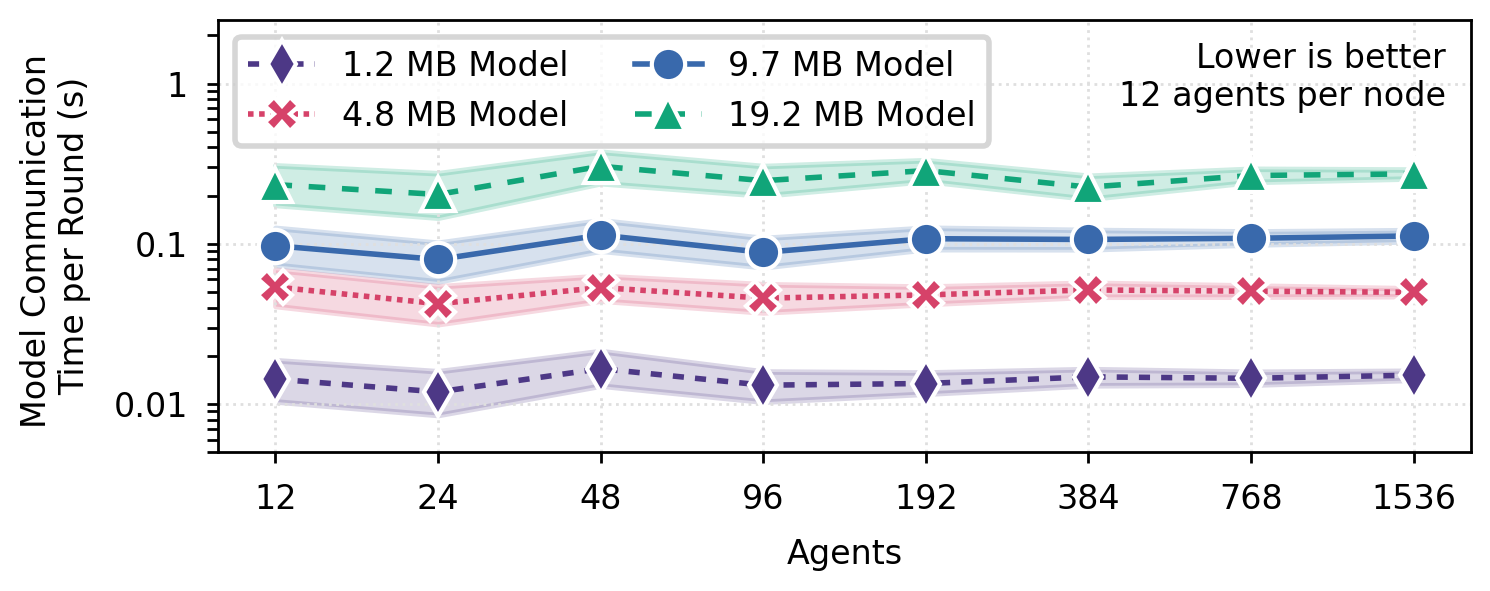

In [21]:
fig, axs = plt.subplots(1, 1)
# ax2 = axs.twiny()

xticks = sorted(set(results['agent_count'].to_list()))
yticks = [0.01, 0.1, 1]  # , 1, 10]

dashes = {'small': (2, 2), 'medium': (1, 1), 'large': (), 'largex2': (3, 3)}
markers = {'small': 'd', 'medium': 'X', 'large': 'o', 'largex2': '^'}
palette = {
    'small': '#4D3886',
    'medium': '#D64269',
    'large': '#3969AC',
    'largex2': '#11A579',
}

df = results.loc[averaged_results['topology'] == 'powerlaw']
handle = seaborn.lineplot(
    df,
    x='agent_count',
    y='push_t',
    hue='model_size',
    hue_order=['small', 'medium', 'large', 'largex2'],
    # errorbar='sd',
    # err_style='bars',
    style='model_size',
    dashes=dashes,
    markers=markers,
    palette=palette,
    ax=axs,
)

handles, _ = axs.get_legend_handles_labels()
plt.legend(
    handles=handles,
    title=None,
    labels=['19.2 MB Model', '9.7 MB Model', '4.8 MB Model', '1.2 MB Model'][
        ::-1
    ],
    #     bbox_to_anchor=(1.6,0.5),
    #    loc='lower right',
    loc='upper left',
    ncol=2,
)
_ = handle.set(
    xscale='log',
    yscale='log',
    xlabel='Agents',
    ylabel='Model Communication \nTime per Round (s)',
)

axs.annotate(
    'Lower is better\n12 agents per node',
    xy=(0.98, 0.95),
    xycoords=('axes fraction'),
    ha='right',
    va='top',
)

axs.set_ylim([0.005, 2.5])
handle.set_xticks(xticks, minor=False)
handle.set_xticklabels([str(x) for x in xticks])
axs.tick_params(axis='x', which='minor', bottom=False)
handle.set_yticks(yticks, minor=False)
handle.set_yticklabels([str(y) for y in yticks])


fig.tight_layout()
fig.set_size_inches(3.5, 1.2)
plt.draw()
fig.savefig('figures/dml-comm-time.pdf')

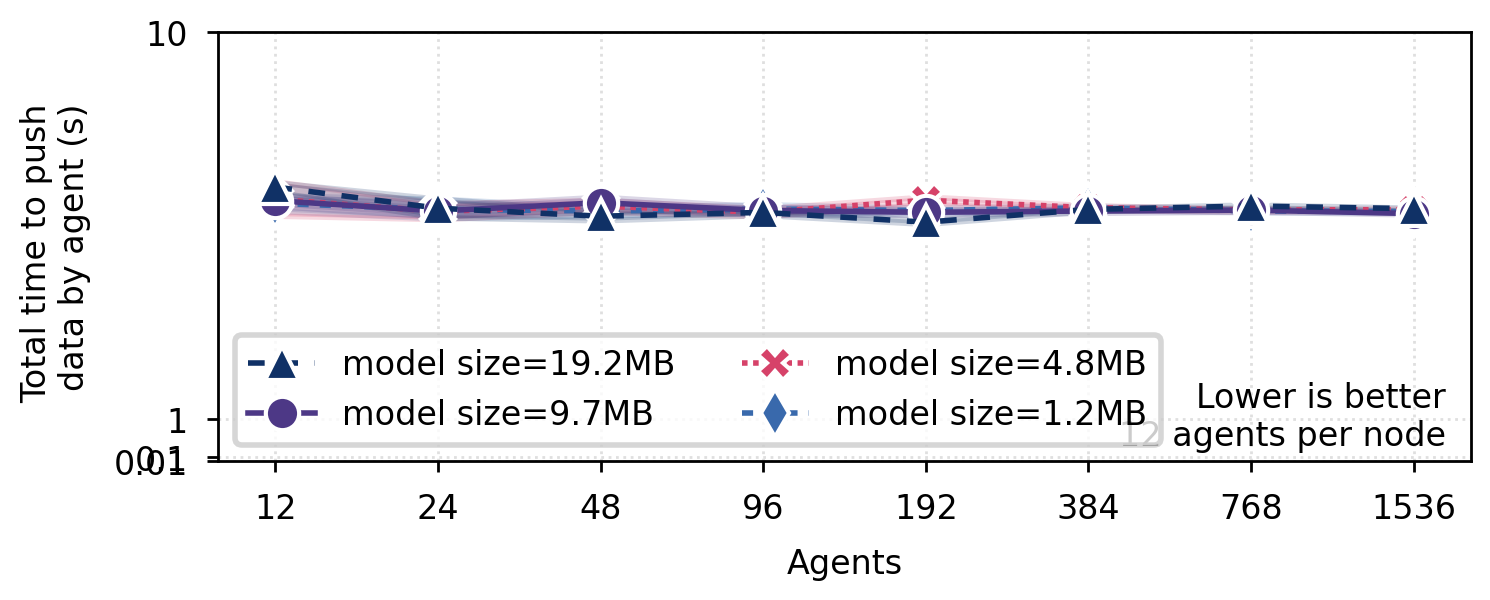

In [12]:
fig, axs = plt.subplots(1, 1)
# ax2 = axs.twiny()

xticks = sorted(set(results['agent_count'].to_list()))
yticks = [0.01, 0.1, 1, 10]

dashes = {'small': (2, 2), 'medium': (1, 1), 'large': (), 'largex2': (3, 3)}
markers = {'small': 'd', 'medium': 'X', 'large': 'o', 'largex2': '^'}
palette = {
    'small': '#3969AC',
    'medium': '#D64269',
    'large': '#4D3886',
    'largex2': '#103166',
}

df = results.loc[results['topology'] == 'powerlaw']
handle = seaborn.lineplot(
    df,
    x='agent_count',
    y='train_t',
    hue='model_size',
    hue_order=['small', 'medium', 'large', 'largex2'],
    # errorbar='sd',
    # err_style='bars',
    style='model_size',
    dashes=dashes,
    markers=markers,
    palette=palette,
    ax=axs,
)

handles, _ = axs.get_legend_handles_labels()
plt.legend(
    handles=handles[::-1],
    title=None,
    labels=[
        'model size=19.2MB',
        'model size=9.7MB',
        'model size=4.8MB',
        'model size=1.2MB',
    ],
    #     bbox_to_anchor=(1.6,0.5),
    #    loc='lower right',
    loc='lower left',
    ncol=2,
)
_ = handle.set(
    xscale='log',
    # yscale='log',
    xlabel='Agents',
    ylabel='Total time to push \ndata by agent (s)',
)

axs.annotate(
    'Lower is better\n12 agents per node',
    xy=(0.98, 0.02),
    xycoords=('axes fraction'),
    ha='right',
    va='bottom',
)

handle.set_xticks(xticks, minor=False)
handle.set_xticklabels([str(x) for x in xticks])
axs.tick_params(axis='x', which='minor', bottom=False)
handle.set_yticks(yticks, minor=False)
handle.set_yticklabels([str(y) for y in yticks])

"""
x_ticks = [12, 24, 48, 96, 192, 384, 768, 1536]
ax2.set_xscale('log')
ax2.set_xlim(axs.get_xlim())
ax2.set_xticks(x_ticks)
ax2.set_xticklabels([avg_neighbors[x] for x in x_ticks])
ax2.set_xlabel(r"Average neighbors per agent")
axs.get_legend().remove()
"""


fig.tight_layout()
fig.set_size_inches(3.5, 1.2)
plt.draw()
fig.savefig('figures/dml-train-time.pdf')

In [ ]:
print(results['train_t'].min())
print(results['train_t'].max())
print(results['train_t'].mean())

In [ ]:
low, high, mean = (
    float(results['agg_t'].min()),
    results['agg_t'].max(),
    results['agg_t'].mean(),
)
print(f'{low:.4f} {high:.4f} {mean:.4f}')